In [1]:
##########################
#this is the code for the Bezier Density Network - general version
##########################

In [2]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle as pk
plt.rcParams["figure.figsize"]=15,15

In [3]:
#define the toy model inverse problem
def inv_model(t):
    #create a an array of uniform random variables
    #eps = np.random.uniform(-0.1,0.1,t.shape)
    #eps = np.random.gamma(2,2,t.shape)/160
    eps = np.random.normal(0,1/10,t.shape)   
    return t + 0.3*np.sin(2*np.pi*t) + eps

def generate_data_model(n):
    #return a random inverse pick for each x
    X = np.random.uniform(0,1,(n*10))
    t = np.random.uniform(0,1,(n))
    Y = inv_model(X)
    #sort by Y
    ind=np.argsort(Y)
    X=X[ind]
    Y=Y[ind]
    Xret=[]
    Yret=[]
    #now for each x pick an X and Y    
    for i in range(len(t)):
        idx = np.argmax(Y>t[i])
        Xret.append(X[idx])
        Yret.append(Y[idx])
    return (torch.Tensor(np.array(Xret)).unsqueeze(1),torch.Tensor(np.array(Yret)).unsqueeze(1))
    
#we create a dataset
version='gaussian'
X_train = np.random.uniform(0,1,(4000))
Y_train = torch.Tensor(inv_model(X_train)).unsqueeze(1)
X_train = torch.Tensor(X_train).unsqueeze(1)

X_val = np.random.uniform(0,1,(4000))
Y_val = torch.Tensor(inv_model(X_val)).unsqueeze(1)
X_val = torch.Tensor(X_val).unsqueeze(1)

X_test = np.random.uniform(0,1,(4000))
Y_test = torch.Tensor(inv_model(X_test)).unsqueeze(1)
X_test = torch.Tensor(X_test).unsqueeze(1)

In [4]:
#normalise the data
train_min = Y_train.min()
train_max = Y_train.max()

def normlise(y):
    return (y-train_min)/(train_max-train_min)

def denormlise(y):
    return y*(train_max-train_min)+train_min

Y_train = normlise(Y_train)
Y_val = normlise(Y_val)
Y_test = normlise(Y_test)


In [5]:
# the score functions
#average negative log predictive density (NLPD) (Good, 1952)
def NLPD(x_obs,y_obs,p):
    #compute the pdfs for each y|x
    t = x_obs.view(-1)
    prob = bezier_pdf(t,p).view(-1,1).numpy()
    #set the minimum to 1/n, taking n=4000 to avoid infinite predictions
    prob = (prob<1/p.shape[0])*1/p.shape[0]+prob*(prob>=1/p.shape[0])
    return -np.sum(np.log(prob))/prob.shape[0]

#MAE to the median of the distribution 
def MAE(x_obs,y_obs,p):
    medians = denormlise(bezier_inv_cdf(0.5*torch.ones(p.shape[0]).view(-1),p).view(-1,1)).numpy()
    return np.sum(np.abs(medians-x_obs.view(-1,1).numpy()))/medians.shape[0]

#Continuous Ranked Probability Score or the CRPS. The CRPS (Gneiting & Raftery, 2004)
def CRPS(x_obs,y_obs,p):
    #resolution 
    res = 1000
    #we get the cdf values at each point
    cdf = None
    for i in range(res):
        this_cdf = bezier_cdf((i/(res-1))*torch.ones(p.shape[0]).view(-1),p).view(-1,1).numpy()
        if (cdf is None):
            cdf=this_cdf
        else:
            cdf=np.concatenate((cdf,this_cdf),axis=1)
    cdf_lhs = cdf*cdf*(cdf<=x_obs.view(-1,1).numpy())
    cdf_rhs = (cdf-1)*(cdf-1)*(cdf>=x_obs.view(-1,1).numpy())
    
    #now compute the approx area using trapezium rule
    cdf_lhs = np.sum(cdf_lhs[:,:-1] +cdf_lhs[:,1:],1)/(res*2)
    cdf_rhs = np.sum(cdf_rhs[:,:-1] +cdf_rhs[:,1:],1)/(res*2)
    crps = np.sum(cdf_lhs+cdf_rhs)/p.shape[0]
    return crps


In [6]:
#### Define the Bezier functions
def bezier(n,t):
    l = t.shape[0]
    b = torch.zeros(l,n+1).to(device)
    for i in range(n+1):
        b[:,i] = (math.factorial(n)/(math.factorial(i)*math.factorial(n-i)))*(t**i)*(1-t)**(n-i)
    return b

def bezier_pdf(t,p):
    n = int(p.shape[1]/2)
    b = bezier(n-2,t)     
    x_delta = p[:,1:n] - p[:,:(n-1)]
    z_delta = p[:,(n+1):] - p[:,n:-1]
    denom=torch.sum(b*x_delta,1)
    prob = torch.sum(b*z_delta,1)/denom
    return prob

def bezier_cdf(t,p):
    n = int(p.shape[1]/2)
    z = p[:,n:]
    x = p[:,:n]
    b = bezier(n-1,t)
    prob = torch.sum(b*z,1)
    return prob

def bezier_inv_cdf(probs,p):
    #now we need to find the t values that correspond to these selections
    l = p.shape[0]
    threshold =0.000001
    max_loops=200
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        prob_mid = bezier_cdf(t_mid,p)
        t_max = t_max*(probs>=prob_mid)+t_mid*(probs<prob_mid)
        t_min = t_min*(probs<prob_mid)+t_mid*(probs>=prob_mid)
    #now we have the t values convert these into x's and return    
    x=t_mid
    return x

def bezier_rnd(p):
    #takes a vector of bezier curves and returns random selections
    #first we get random selections in 0,1
    l = p.shape[0]
    probs = torch.FloatTensor(l).uniform_(0.0, 1.0).to(device)
    #now we need to find the t values that correspond to these selections
    threshold =0.000001
    max_loops=200
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        prob_mid = bezier_cdf(t_mid,p)
        t_max = t_max*(probs>=prob_mid)+t_mid*(probs<prob_mid)
        t_min = t_min*(probs<prob_mid)+t_mid*(probs>=prob_mid)
    #now we have the t values convert these into x's and return    
    x=t_mid
    return x

def bezier_x(p,t):
    #given a t return corresponding x under bezier p
    n = int(p.shape[1]/2)
    b = bezier(n-1,t)
    return torch.sum(b*p[:,:n],1)

def bezier_t(p,x):
    l = x.shape[0]
    #given an x return correspoding t under bezier p
    #interpolate
    threshold =0.0001
    max_loops=50
    t_min=torch.zeros(l).to(device)
    t_max=torch.ones(l).to(device)
    while((max_loops>0) and (torch.sum(t_max-t_min)>=threshold)):
        max_loops-=1
        t_mid = (t_min+t_max)/2
        x_mid = bezier_x(p,t_mid)
        t_max = t_max*(x[:,0]>=x_mid)+t_mid*(x[:,0]<x_mid)
        t_min = t_min*(x[:,0]<x_mid)+t_mid*(x[:,0]>=x_mid)
    return t_mid

GPU not available, CPU used
epoch = 0 train loss = 0.5224567651748657 validation loss = 0.5521907210350037
epoch = 1 train loss = 0.46876630187034607 validation loss = 0.42252418398857117
epoch = 2 train loss = 0.4728579521179199 validation loss = 0.5901653170585632
epoch = 3 train loss = 0.8206261396408081 validation loss = 0.8603607416152954
epoch = 4 train loss = 0.9537565112113953 validation loss = 1.0859192609786987
epoch = 5 train loss = 0.9883849024772644 validation loss = 1.2276016473770142
epoch = 6 train loss = 1.2731529474258423 validation loss = 1.164900541305542
epoch = 7 train loss = 1.145875334739685 validation loss = 1.1265407800674438
epoch = 8 train loss = 1.0704442262649536 validation loss = 1.0172847509384155
epoch = 9 train loss = 0.8319491744041443 validation loss = 0.8007185459136963
epoch = 10 train loss = 0.840923011302948 validation loss = 0.6474446058273315
epoch = 11 train loss = 0.7337958216667175 validation loss = 0.6290954351425171
epoch = 12 train loss =

epoch = 100 train loss = -0.3621366620063782 validation loss = -0.40623533725738525
epoch = 101 train loss = -0.3909328877925873 validation loss = -0.4074687361717224
epoch = 102 train loss = -0.3768763542175293 validation loss = -0.4126943051815033
epoch = 103 train loss = -0.3908516764640808 validation loss = -0.4079952836036682
epoch = 104 train loss = -0.40565913915634155 validation loss = -0.3950651288032532
epoch = 105 train loss = -0.3978808522224426 validation loss = -0.41051343083381653
epoch = 106 train loss = -0.3911251723766327 validation loss = -0.419570654630661
epoch = 107 train loss = -0.4044395089149475 validation loss = -0.41770684719085693
epoch = 108 train loss = -0.3918983042240143 validation loss = -0.40927794575691223
epoch = 109 train loss = -0.3999423682689667 validation loss = -0.4206298589706421
epoch = 110 train loss = -0.3889131546020508 validation loss = -0.42102569341659546
epoch = 111 train loss = -0.3947490453720093 validation loss = -0.4203848540782928

epoch = 198 train loss = -0.40731167793273926 validation loss = -0.4717951714992523
epoch = 199 train loss = -0.43848535418510437 validation loss = -0.4655558168888092
epoch = 200 train loss = -0.4457126557826996 validation loss = -0.47575151920318604
epoch = 201 train loss = -0.4448169767856598 validation loss = -0.4606951177120209
epoch = 202 train loss = -0.4340364634990692 validation loss = -0.457183837890625
epoch = 203 train loss = -0.4300506114959717 validation loss = -0.46924853324890137
epoch = 204 train loss = -0.44014865159988403 validation loss = -0.4559036195278168
epoch = 205 train loss = -0.4761454463005066 validation loss = -0.46593788266181946
epoch = 206 train loss = -0.4548662006855011 validation loss = -0.46108293533325195
epoch = 207 train loss = -0.47903919219970703 validation loss = -0.47156447172164917
epoch = 208 train loss = -0.45658716559410095 validation loss = -0.4739101231098175
epoch = 209 train loss = -0.42499297857284546 validation loss = -0.45677492022

epoch = 297 train loss = -0.5235472321510315 validation loss = -0.49268588423728943
epoch = 298 train loss = -0.477576345205307 validation loss = -0.4710264503955841
epoch = 299 train loss = -0.4597386121749878 validation loss = -0.4257219433784485
epoch = 300 train loss = -0.4671330451965332 validation loss = -0.48349347710609436
epoch = 301 train loss = -0.5368548631668091 validation loss = -0.49010175466537476
epoch = 302 train loss = -0.4918535649776459 validation loss = -0.4823802709579468
epoch = 303 train loss = -0.5519205331802368 validation loss = -0.4994232952594757
epoch = 304 train loss = -0.4910547733306885 validation loss = -0.4998636841773987
epoch = 305 train loss = -0.4830257296562195 validation loss = -0.5055552124977112
epoch = 306 train loss = -0.4994300603866577 validation loss = -0.5237506628036499
epoch = 307 train loss = -0.5224753022193909 validation loss = -0.52635657787323
epoch = 308 train loss = -0.5028191208839417 validation loss = -0.5148540139198303
epoc

epoch = 396 train loss = -0.5541151165962219 validation loss = -0.5366023182868958
epoch = 397 train loss = -0.5375939607620239 validation loss = -0.5898458361625671
epoch = 398 train loss = -0.5354638695716858 validation loss = -0.5374355316162109
epoch = 399 train loss = -0.5468259453773499 validation loss = -0.5687428116798401
epoch = 400 train loss = -0.5428034663200378 validation loss = -0.5635597109794617
epoch = 401 train loss = -0.5560265183448792 validation loss = -0.5412603616714478
epoch = 402 train loss = -0.4787188768386841 validation loss = -0.4577832520008087
epoch = 403 train loss = -0.4377017915248871 validation loss = -0.4417033791542053
epoch = 404 train loss = -0.41944900155067444 validation loss = -0.41890329122543335
epoch = 405 train loss = -0.46088603138923645 validation loss = -0.45980584621429443
epoch = 406 train loss = -0.4132367670536041 validation loss = -0.4081483781337738
epoch = 407 train loss = -0.3745235204696655 validation loss = -0.4348202645778656


epoch = 495 train loss = -0.5074976086616516 validation loss = -0.5780767798423767
epoch = 496 train loss = -0.5966525673866272 validation loss = -0.5623958706855774
epoch = 497 train loss = -0.5522541403770447 validation loss = -0.561465322971344
epoch = 498 train loss = -0.5365726947784424 validation loss = -0.5486031770706177
epoch = 499 train loss = -0.5300145745277405 validation loss = -0.5881855487823486
epoch = 500 train loss = -0.5659303069114685 validation loss = -0.5680127143859863
epoch = 501 train loss = -0.6060383915901184 validation loss = -0.5863313674926758
epoch = 502 train loss = -0.5690850615501404 validation loss = -0.5705659985542297
epoch = 503 train loss = -0.5609006285667419 validation loss = -0.5626988410949707
epoch = 504 train loss = -0.5095807313919067 validation loss = -0.5965119004249573
epoch = 505 train loss = -0.5341891050338745 validation loss = -0.5721467137336731
epoch = 506 train loss = -0.5679282546043396 validation loss = -0.5533038377761841
epoch

epoch = 594 train loss = -0.5894485116004944 validation loss = -0.5962016582489014
epoch = 595 train loss = -0.5696544647216797 validation loss = -0.5791919231414795
epoch = 596 train loss = -0.5898425579071045 validation loss = -0.5977428555488586
epoch = 597 train loss = -0.6050825119018555 validation loss = -0.5851325392723083
epoch = 598 train loss = -0.5527831315994263 validation loss = -0.5950348377227783
epoch = 599 train loss = -0.5855048894882202 validation loss = -0.5876044631004333
epoch = 600 train loss = -0.5969784259796143 validation loss = -0.6013676524162292
epoch = 601 train loss = -0.5631582140922546 validation loss = -0.6089431643486023
epoch = 602 train loss = -0.6019561290740967 validation loss = -0.5909440517425537
epoch = 603 train loss = -0.5771548748016357 validation loss = -0.5889655947685242
epoch = 604 train loss = -0.585388720035553 validation loss = -0.5931944847106934
epoch = 605 train loss = -0.5844305753707886 validation loss = -0.5889508128166199
epoch

epoch = 693 train loss = -0.5895403027534485 validation loss = -0.615580677986145
epoch = 694 train loss = -0.5935801267623901 validation loss = -0.6160813570022583
epoch = 695 train loss = -0.5865305066108704 validation loss = -0.6162188649177551
epoch = 696 train loss = -0.5780624151229858 validation loss = -0.5972476601600647
epoch = 697 train loss = -0.5744059681892395 validation loss = -0.6163065433502197
epoch = 698 train loss = -0.6159214377403259 validation loss = -0.6031720042228699
epoch = 699 train loss = -0.5621403455734253 validation loss = -0.6285676956176758
epoch = 700 train loss = -0.614138662815094 validation loss = -0.6061766743659973
epoch = 701 train loss = -0.5385230779647827 validation loss = -0.5223988890647888
epoch = 702 train loss = -0.5360864996910095 validation loss = -0.5017091631889343
epoch = 703 train loss = -0.5127139091491699 validation loss = -0.4484776258468628
epoch = 704 train loss = -0.4314803183078766 validation loss = -0.44302698969841003
epoch

epoch = 792 train loss = -0.5757625699043274 validation loss = -0.5872563719749451
epoch = 793 train loss = -0.5666027665138245 validation loss = -0.6034837961196899
epoch = 794 train loss = -0.5268774032592773 validation loss = -0.5817418098449707
epoch = 795 train loss = -0.5744022130966187 validation loss = -0.6067171096801758
epoch = 796 train loss = -0.5912351608276367 validation loss = -0.5621985793113708
epoch = 797 train loss = -0.5590218901634216 validation loss = -0.5664470195770264
epoch = 798 train loss = -0.5437561273574829 validation loss = -0.5842774510383606
epoch = 799 train loss = -0.5438684225082397 validation loss = -0.6018190383911133
epoch = 800 train loss = -0.5523161888122559 validation loss = -0.5806464552879333
epoch = 801 train loss = -0.6077138185501099 validation loss = -0.6055076122283936
epoch = 802 train loss = -0.6007007956504822 validation loss = -0.5668821334838867
epoch = 803 train loss = -0.6105902194976807 validation loss = -0.6004437208175659
epoc

epoch = 891 train loss = -0.6117807626724243 validation loss = -0.6503806114196777
epoch = 892 train loss = -0.6006152629852295 validation loss = -0.6436296105384827
epoch = 893 train loss = -0.5924376845359802 validation loss = -0.6038387417793274
epoch = 894 train loss = -0.6042577624320984 validation loss = -0.5902098417282104
epoch = 895 train loss = -0.6044129133224487 validation loss = -0.5943233966827393
epoch = 896 train loss = -0.6166483163833618 validation loss = -0.6319231986999512
epoch = 897 train loss = -0.6259561777114868 validation loss = -0.5879768133163452
epoch = 898 train loss = -0.6039363145828247 validation loss = -0.5746604800224304
epoch = 899 train loss = -0.6167963147163391 validation loss = -0.5848305821418762
epoch = 900 train loss = -0.644824743270874 validation loss = -0.5942861437797546
epoch = 901 train loss = -0.6022428870201111 validation loss = -0.6075298190116882
epoch = 902 train loss = -0.5341387391090393 validation loss = -0.5316544771194458
epoch

epoch = 990 train loss = -0.5747957229614258 validation loss = -0.6280931830406189
epoch = 991 train loss = -0.623103678226471 validation loss = -0.6327985525131226
epoch = 992 train loss = -0.6309943795204163 validation loss = -0.6336559057235718
epoch = 993 train loss = -0.5968704223632812 validation loss = -0.6210993528366089
epoch = 994 train loss = -0.5977658629417419 validation loss = -0.5973373055458069
epoch = 995 train loss = -0.6048927903175354 validation loss = -0.5954618453979492
epoch = 996 train loss = -0.6083601117134094 validation loss = -0.619728147983551
epoch = 997 train loss = -0.5528872609138489 validation loss = -0.6185489892959595
epoch = 998 train loss = -0.5352454781532288 validation loss = -0.5938646793365479
epoch = 999 train loss = -0.5794768929481506 validation loss = -0.6085121035575867
epoch = 1000 train loss = -0.5952502489089966 validation loss = -0.627403974533081
epoch = 1001 train loss = -0.6175516843795776 validation loss = -0.652592658996582
epoch 

epoch = 1088 train loss = -0.6142566204071045 validation loss = -0.5951501727104187
epoch = 1089 train loss = -0.604916512966156 validation loss = -0.6306419968605042
epoch = 1090 train loss = -0.6529914140701294 validation loss = -0.6129150390625
epoch = 1091 train loss = -0.6027472019195557 validation loss = -0.6248090863227844
epoch = 1092 train loss = -0.5985985398292542 validation loss = -0.6414649486541748
epoch = 1093 train loss = -0.5891762971878052 validation loss = -0.6162052154541016
epoch = 1094 train loss = -0.6037485003471375 validation loss = -0.624282956123352
epoch = 1095 train loss = -0.6465450525283813 validation loss = -0.6277421116828918
epoch = 1096 train loss = -0.614387035369873 validation loss = -0.6318624019622803
epoch = 1097 train loss = -0.6310908198356628 validation loss = -0.6167293190956116
epoch = 1098 train loss = -0.6230981945991516 validation loss = -0.5886417031288147
epoch = 1099 train loss = -0.6114689707756042 validation loss = -0.630353450775146

epoch = 1186 train loss = -0.5110087394714355 validation loss = -0.5597802996635437
epoch = 1187 train loss = -0.5722652077674866 validation loss = -0.610621988773346
epoch = 1188 train loss = -0.585189700126648 validation loss = -0.5998035669326782
epoch = 1189 train loss = -0.615791916847229 validation loss = -0.6187646985054016
epoch = 1190 train loss = -0.611665666103363 validation loss = -0.6126337647438049
epoch = 1191 train loss = -0.5917227864265442 validation loss = -0.5979001522064209
epoch = 1192 train loss = -0.5773424506187439 validation loss = -0.6354500651359558
epoch = 1193 train loss = -0.5977938175201416 validation loss = -0.6174741387367249
epoch = 1194 train loss = -0.5902895331382751 validation loss = -0.6011720895767212
epoch = 1195 train loss = -0.618881106376648 validation loss = -0.5942476987838745
epoch = 1196 train loss = -0.5977100133895874 validation loss = -0.6195856928825378
epoch = 1197 train loss = -0.5732359290122986 validation loss = -0.60073584318161

epoch = 1284 train loss = -0.6253073215484619 validation loss = -0.6431794762611389
epoch = 1285 train loss = -0.6114438772201538 validation loss = -0.6265039443969727
epoch = 1286 train loss = -0.654531717300415 validation loss = -0.631997287273407
epoch = 1287 train loss = -0.6246698498725891 validation loss = -0.6322458386421204
epoch = 1288 train loss = -0.5820794701576233 validation loss = -0.6351027488708496
epoch = 1289 train loss = -0.6414647102355957 validation loss = -0.6252230405807495
epoch = 1290 train loss = -0.6161649823188782 validation loss = -0.6015787124633789
epoch = 1291 train loss = -0.6001415252685547 validation loss = -0.6296111941337585
epoch = 1292 train loss = -0.5927093029022217 validation loss = -0.6010339856147766
epoch = 1293 train loss = -0.6324555277824402 validation loss = -0.6086845993995667
epoch = 1294 train loss = -0.6144942045211792 validation loss = -0.6441370248794556
epoch = 1295 train loss = -0.6104057431221008 validation loss = -0.62758636474

epoch = 1382 train loss = -0.5900723934173584 validation loss = -0.6447119116783142
epoch = 1383 train loss = -0.625749945640564 validation loss = -0.6264214515686035
epoch = 1384 train loss = -0.5981195569038391 validation loss = -0.6285154223442078
epoch = 1385 train loss = -0.6375349760055542 validation loss = -0.638137698173523
epoch = 1386 train loss = -0.6271418929100037 validation loss = -0.6183051466941833
epoch = 1387 train loss = -0.6556802988052368 validation loss = -0.6183886528015137
epoch = 1388 train loss = -0.6226930618286133 validation loss = -0.6403259634971619
epoch = 1389 train loss = -0.6100009083747864 validation loss = -0.6295002102851868
epoch = 1390 train loss = -0.6274125576019287 validation loss = -0.638961136341095
epoch = 1391 train loss = -0.6058502197265625 validation loss = -0.658877432346344
epoch = 1392 train loss = -0.6285176873207092 validation loss = -0.6491242051124573
epoch = 1393 train loss = -0.6315429210662842 validation loss = -0.6235425472259

epoch = 1480 train loss = -0.611232340335846 validation loss = -0.6195166110992432
epoch = 1481 train loss = -0.6629326939582825 validation loss = -0.6290187835693359
epoch = 1482 train loss = -0.591047465801239 validation loss = -0.6185256242752075
epoch = 1483 train loss = -0.6213999390602112 validation loss = -0.6298093199729919
epoch = 1484 train loss = -0.5906115174293518 validation loss = -0.6095083951950073
epoch = 1485 train loss = -0.595066487789154 validation loss = -0.6422013640403748
epoch = 1486 train loss = -0.6338694095611572 validation loss = -0.6171687245368958
epoch = 1487 train loss = -0.6198065280914307 validation loss = -0.6174822449684143
epoch = 1488 train loss = -0.647059977054596 validation loss = -0.6245576739311218
epoch = 1489 train loss = -0.6264563798904419 validation loss = -0.6231839656829834
epoch = 1490 train loss = -0.6038574576377869 validation loss = -0.6080445647239685
epoch = 1491 train loss = -0.5714120864868164 validation loss = -0.6133202910423

epoch = 1578 train loss = -0.6080986261367798 validation loss = -0.6214280128479004
epoch = 1579 train loss = -0.6418484449386597 validation loss = -0.621349036693573
epoch = 1580 train loss = -0.572132408618927 validation loss = -0.6144139170646667
epoch = 1581 train loss = -0.6027174592018127 validation loss = -0.6624509692192078
epoch = 1582 train loss = -0.614960253238678 validation loss = -0.6412862539291382
epoch = 1583 train loss = -0.595745861530304 validation loss = -0.6339386105537415
epoch = 1584 train loss = -0.6010515093803406 validation loss = -0.6479510068893433
epoch = 1585 train loss = -0.6049408912658691 validation loss = -0.6212687492370605
epoch = 1586 train loss = -0.6371615529060364 validation loss = -0.6687840223312378
epoch = 1587 train loss = -0.6046579480171204 validation loss = -0.6357554793357849
epoch = 1588 train loss = -0.6376605033874512 validation loss = -0.636925220489502
epoch = 1589 train loss = -0.6125973463058472 validation loss = -0.64777231216430

epoch = 1676 train loss = -0.5767677426338196 validation loss = -0.6147441267967224
epoch = 1677 train loss = -0.5890229940414429 validation loss = -0.6287743449211121
epoch = 1678 train loss = -0.6061175465583801 validation loss = -0.6128631830215454
epoch = 1679 train loss = -0.5924648642539978 validation loss = -0.5868819355964661
epoch = 1680 train loss = -0.5948737263679504 validation loss = -0.5415827035903931
epoch = 1681 train loss = -0.5403590202331543 validation loss = -0.5471329689025879
epoch = 1682 train loss = -0.5365476012229919 validation loss = -0.5378896594047546
epoch = 1683 train loss = -0.5733950138092041 validation loss = -0.5355330109596252
epoch = 1684 train loss = -0.5675065517425537 validation loss = -0.5559098720550537
epoch = 1685 train loss = -0.5427572727203369 validation loss = -0.5634156465530396
epoch = 1686 train loss = -0.6024495363235474 validation loss = -0.5604833960533142
epoch = 1687 train loss = -0.5519765019416809 validation loss = -0.593946635

epoch = 1774 train loss = -0.600064754486084 validation loss = -0.6220836639404297
epoch = 1775 train loss = -0.6122719645500183 validation loss = -0.6162018179893494
epoch = 1776 train loss = -0.6361873149871826 validation loss = -0.6334815621376038
epoch = 1777 train loss = -0.6012646555900574 validation loss = -0.6165292859077454
epoch = 1778 train loss = -0.6182984709739685 validation loss = -0.6232316493988037
epoch = 1779 train loss = -0.6308088898658752 validation loss = -0.6238195896148682
epoch = 1780 train loss = -0.5816408395767212 validation loss = -0.622050940990448
epoch = 1781 train loss = -0.6104431748390198 validation loss = -0.6149969100952148
epoch = 1782 train loss = -0.6110866069793701 validation loss = -0.6052749752998352
epoch = 1783 train loss = -0.629885733127594 validation loss = -0.6329169869422913
epoch = 1784 train loss = -0.6465345621109009 validation loss = -0.628966748714447
epoch = 1785 train loss = -0.6078805923461914 validation loss = -0.6184953451156

epoch = 1872 train loss = -0.6334038376808167 validation loss = -0.6415752172470093
epoch = 1873 train loss = -0.6343461871147156 validation loss = -0.6456304788589478
epoch = 1874 train loss = -0.6521074771881104 validation loss = -0.6411415934562683
epoch = 1875 train loss = -0.606742262840271 validation loss = -0.6437127590179443
epoch = 1876 train loss = -0.6368818283081055 validation loss = -0.6472288966178894
epoch = 1877 train loss = -0.628112256526947 validation loss = -0.6284509897232056
epoch = 1878 train loss = -0.6328888535499573 validation loss = -0.6280801892280579
epoch = 1879 train loss = -0.5935150980949402 validation loss = -0.6359373331069946
epoch = 1880 train loss = -0.6088943481445312 validation loss = -0.6318733096122742
epoch = 1881 train loss = -0.6593695878982544 validation loss = -0.6346476078033447
epoch = 1882 train loss = -0.6285669803619385 validation loss = -0.6492988467216492
epoch = 1883 train loss = -0.6114286184310913 validation loss = -0.63603478670

epoch = 1970 train loss = -0.5839567184448242 validation loss = -0.6490790843963623
epoch = 1971 train loss = -0.6288511157035828 validation loss = -0.6364739537239075
epoch = 1972 train loss = -0.6076815128326416 validation loss = -0.6637320518493652
epoch = 1973 train loss = -0.6074413657188416 validation loss = -0.6519719362258911
epoch = 1974 train loss = -0.6300574541091919 validation loss = -0.6441453695297241
epoch = 1975 train loss = -0.6170089840888977 validation loss = -0.6397876143455505
epoch = 1976 train loss = -0.6348535418510437 validation loss = -0.6542474031448364
epoch = 1977 train loss = -0.5996517539024353 validation loss = -0.635940670967102
epoch = 1978 train loss = -0.6265632510185242 validation loss = -0.6259410977363586
epoch = 1979 train loss = -0.6210841536521912 validation loss = -0.6422876119613647
epoch = 1980 train loss = -0.6478961110115051 validation loss = -0.655499279499054
epoch = 1981 train loss = -0.6180339455604553 validation loss = -0.65157753229

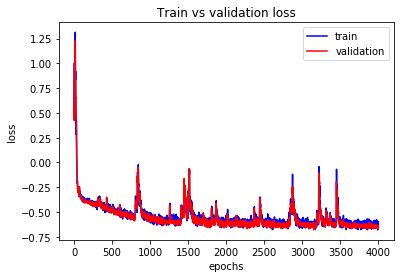

In [7]:
#######################
#### Bezier Density Network to fit the inverse function
#######################
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
def Bezier_Output_Layer(x,finetune):
    #we convert the final layer of the network into the Bezier outputs
    with torch.no_grad():
        #we get the number of control points
        n=int((x.shape[1]+3)/2)
        l = x.shape[0]
    #set the x values of the control points
    p_x = x[:,:(n-1)] 
    #constrain the x values between 0 and 1 ascending using cumsum
    p_x =torch.exp(p_x)
    p_x = torch.cumsum(p_x,1)/torch.sum(p_x,1).view(-1,1)
    p_x0 = torch.zeros((l,1)).to(device)
    p_z0 = torch.zeros((l,1)).to(device)
    #We constrain the z values of the control points between -1 and +2
    p_z1 = torch.ones((l,1)).to(device)
    p_z = x[:,(n-1):(2*n-3)]
    p_z = (3/(1+torch.exp(p_z)))-1
    
    #set the final outputs
    p_x = torch.cat((p_x0,p_x),1)
    p_z = torch.cat((p_z0,p_z,p_z1),1)    
    p = torch.cat((p_x,p_z),1)
    return p

def Bezier_loss(x,y):
    #we compute the MDN loss using a custom loss function
    with torch.no_grad():
        #get the number of control points
        n=int(x.shape[1]/2)
        batch_len=x.shape[0]    
    t=y.view(-1)
    
    #take the finite difference of the cdf
    prob = (-bezier_cdf(t-0.0001,x)+bezier_cdf(t+0.0001,x))/.0002
    
    #we define the weight penalty for negative densities (higher values will remove all negative densities)
    C=1
    #compute the log probaility applying the formaula for negative proability densities
    prob = torch.log((prob)*(prob>0)+(prob<=0))+prob*(prob<0)*(C)   
    #Add in random picks to check for negative probability densities
    rnd_noise = torch.FloatTensor(batch_len).uniform_(0.0, 1.0).to(device)
    #compiute the finite difference of the CDF at the random point
    rnd_prob = (-bezier_cdf(rnd_noise-0.0001,x)+bezier_cdf(rnd_noise+0.0001,x))/0.0002
    #if the random point has a negative porobaility density penalise with C
    prob+=rnd_prob*(rnd_prob<0)*(C)
    #Now compute the negative average sum
    loss=-torch.sum(prob)/x.shape[0]
    return loss

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.finetune=False
        self.regressor = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, (50*2-3))
        )
    def set_finetune(self,finetune):
        self.finetune = finetune
        
    def forward(self, x):
        x = self.regressor(x)
        #apply the custom output layer
        return Bezier_Output_Layer(x,self.finetune)

net = Net().to(device)
params = list(net.parameters())

#apply the bezier loss
criterion = Bezier_loss
optimizer = optim.Adam(net.parameters(),lr=0.01,weight_decay=0.00) 

loss_v=[]
loss_t=[]
    
traindata = TensorDataset( X_train,Y_train )
dataloader = DataLoader(traindata, batch_size= 2000, shuffle=True) 

for epoch in range(2000):
    net.train()
    ######NOTE THAT WE SWAP THE X AND Y HERE ######### 
    for batch_idx, (Y, X) in enumerate(dataloader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = net(X.to(device))
        loss = criterion(outputs, Y.to(device))
        loss.backward()
        optimizer.step()
        loss_t.append(loss.item())     
        #evaluate the loss on validation set   
        loss_v.append(criterion(net(Y_val.to(device)), X_val.to(device)).item())
    print(f"epoch = {epoch} train loss = {loss_t[-1]} validation loss = {loss_v[-1]}")
        
print('Finished Training')

plt.plot(loss_t, "-b", label="train")
plt.plot(loss_v , "-r", label="validation")
plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train vs validation loss")

plt.show()

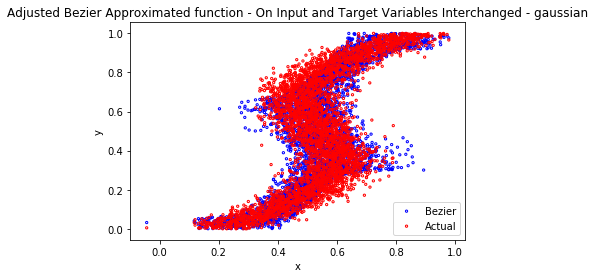

In [8]:
#plot the scatter
Y_test_new = probs = torch.FloatTensor(4000,1).uniform_(0.0, 1.0).to(device)
X_test_predict_Bezier = net(Y_test.to(device)).detach()#.numpy()
X_test_predict = bezier_rnd(X_test_predict_Bezier)
plt.scatter(Y_test.cpu().numpy(),X_test_predict.cpu().numpy(), color='blue', marker='o',s=5,facecolors='none', label="Bezier")
plt.scatter(Y_test.cpu().numpy(),X_test.cpu().numpy(), color='red', marker='o',s=5,facecolors='none', label="Actual")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Adjusted Bezier Approximated function - On Input and Target Variables Interchanged - " + version)
plt.show()    

22


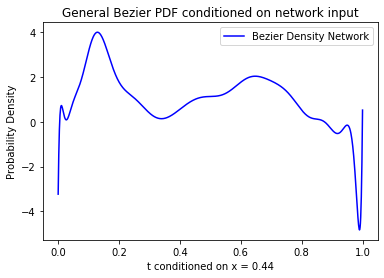

In [9]:
#plot a bezier for a given x (eval_at)
t = torch.linspace(0,1,1000)
eval_at = 0.43

for i in range(Y_test.shape[0]):
    if((Y_test[i]>eval_at) and (Y_test[i]<eval_at+.02)):
        print(i)
        break
num = i

p = X_test_predict_Bezier[num,:].view(1,-1)
x = Y_test[num]

x_val = bezier_pdf(t,p)
plt.plot(t,x_val.cpu(), color='blue', label="Bezier Density Network")
plt.legend(loc="upper right")
plt.xlabel("t conditioned on x = " + str(round(x.item(),2)))
plt.ylabel("Probability Density")
plt.title("General Bezier PDF conditioned on network input")
plt.show()

NLPD = -0.7655647053245211
MAE = 0.27052877807617187
CRPS = 0.09092732238769531


Text(0.5, 1.0, 'General BDN - gaussian')

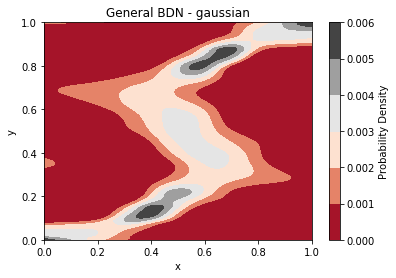

In [10]:
p = net(Y_test.to(device)).detach()
#compute the scores
print(f"NLPD = {NLPD(X_test,Y_test,p)}")
print(f"MAE = {MAE(X_test,Y_test,p)}")
print(f"CRPS = {CRPS(X_test,Y_test,p)}")
#density plot
Y_density = torch.linspace(0.0, 1.0,1000).view(-1,1).to(device)
X_density = torch.linspace(0.0, 1.0,1000).view(-1,1).to(device)
X_density_Bezier = net(Y_density.to(device)).detach()#.numpy()
X, Y = torch.meshgrid(X_density.view(-1), Y_density.view(-1))
Z = torch.zeros(X.shape)
for i in range(1000):
    Z[:,i] = bezier_pdf(X[i,:],X_density_Bezier)
    Z[:,i] = Z[:,i]*(Z[:,i]>0)
    Z[:,i] = Z[:,i]/torch.sum(Z[:,i])
plt.contourf(X, Y, Z, 5, cmap='RdGy')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability Density', rotation=90)
plt.xlabel("x")
plt.ylabel("y")
plt.title("General BDN - " + version)